# Mental Health Screening Checklist

In [1]:
# imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from pyod.models.iforest import IForest
from IPython.display import display_html 

# customize pandas
pd.set_option("display.max_rows", None)

# customize matplolib
rcParams['font.family'] = ['Trebuchet MS']

In [2]:
# load dataset
df = pd.read_csv("mhsc_data.csv", index_col=0)

In [3]:
# set relevant labels
# for some features, different values are collapsed into same label (e.g., see age_labels)
gender_labels = ["M", "F"]
age_labels = ["17-30", "31-50", "31-50", "51-99", "51-99"] 
job_labels = ["Pilot", "Pilot Applicant", "Cabin Crew", "ATC", "Other"]
status_labels = ["Military", "Civilian", "Other"]

# convert bio features to categorical
df["bio_gender"] = pd.cut(df["bio_gender"], bins=[0,1,2], labels=gender_labels, ordered=False)
df["bio_age"] = pd.cut(df["bio_age"], bins=[0,1,2,3,4,5], labels=age_labels, ordered=False)
df["bio_job"] = pd.cut(df["bio_job"], bins=[0,1,2,3,4,5], labels=job_labels, ordered=False)
df["bio_status"] =  pd.cut(df["bio_status"], bins=[0,1,2,3], labels=status_labels, ordered=False)

In [4]:
# limit data to pilots, cabin crew and pilot applicants
df = df[df["bio_job"].isin(["Pilot","Cabin Crew", "Pilot Applicant"])]
display(df.shape)
df.head(2)

(240, 29)

,bio_gender,bio_age,bio_job,bio_status,enac_self_assessment,enac_self_report_atypical,enac_interview_atypical,enac_need_referral,mhsc_01_01,mhsc_01_02,...,mhsc_02_02,mhsc_02_03,mhsc_02_04,mhsc_02_05,mhsc_03_01,mhsc_03_02,mhsc_03_03,mhsc_03_04,mhsc_03_05,mhsc_04_01
bio_id,,,,,,,,,,,,,,,,,,,,,
1,F,17-30,Cabin Crew,Civilian,7,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,7
2,F,17-30,Cabin Crew,Civilian,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


# 1. GENERAL STATS

## 1.1 BIOGRAPHICAL DATA

In [5]:
# generate table for biographical data
def make_table_bio(df, col):
    col_mapper = {col: (col.split("_")[1]).capitalize(), "count": "Freq", "proportion": "%"}
    prop = df[col].value_counts(normalize=True).to_frame() * 100
    freq = df[col].value_counts().to_frame()
    table = prop.merge(freq, left_index=True, right_index=True)
    return (table
         .reset_index(drop=False)
         .style
            .hide()
            .format(precision=1)
            .format_index(lambda x: col_mapper[x], axis=1)
            .set_table_attributes("style='display:inline;margin-right:48px'")
            .to_html()
)

In [6]:
html = ""
for col in df.filter(regex="bio_(?!status)"):
    html += make_table_bio(df, col)
    
display_html(html, raw=True)

Gender,%,Freq
M,88.8,213
F,11.2,27
Age,%,Freq
17-30,46.7,112
31-50,33.8,81
51-99,19.6,47
Job,%,Freq
Pilot,52.5,126
Pilot Applicant,32.1,77
Cabin Crew,15.4,37


## 1.2 ITEM ENDORSMENT RATES

In [7]:
# generate table for mhsc parts
def make_mhsc_part_table(part):
    
    # utility
    def make_table(part, job = None):
        data = df
        if job != None:
            data = df[df["bio_job"] == job]
        return (
            (data.filter(regex=part).clip(0,1).sum() / df.shape[0])
            .to_frame()
            .reset_index(drop=False)
            .rename(columns={"index": "Item", 0: "%"})
        )
    
    part = (
    make_table(part)
        .merge(make_table(part, "Pilot"), left_on="Item", right_on="Item", suffixes=("a","b"))
        .merge(make_table(part, "Cabin Crew"), left_on="Item", right_on="Item")
        .merge(make_table(part, "Pilot Applicant"), left_on="Item", right_on="Item")
    )
    return (part
                .rename(columns={"%a":"Item","%a":"Total","%b":"Pilots","%_x":"Crew","%_y":"Applicants"})
                .style
                    .format(precision=2)
                    .hide()
                    .background_gradient(
                        cmap="GnBu", axis=1, subset=["Pilots","Crew","Applicants"]
                    )
                    .format(lambda x: round(x*100, 1), subset=["Total","Pilots","Crew","Applicants"])
           )
    

### 1.2.1 MHSC PART 1

## make_mhsc_part_table("mhsc_01")

### 1.2.2 MSHC PART 2

In [8]:
make_mhsc_part_table("mhsc_02")

Item,Total,Pilots,Crew,Applicants
mhsc_02_01,87.1,45.4,12.9,28.7
mhsc_02_02,67.5,34.6,9.6,23.3
mhsc_02_03,19.6,9.2,4.6,5.8
mhsc_02_04,0.0,0.0,0.0,0.0
mhsc_02_05,0.0,0.0,0.0,0.0


### 1.2.3 MSHC PART 3

In [9]:
make_mhsc_part_table("mhsc_03")

Item,Total,Pilots,Crew,Applicants
mhsc_03_01,3.3,0.0,1.2,2.1
mhsc_03_02,0.4,0.0,0.0,0.4
mhsc_03_03,2.5,1.7,0.0,0.8
mhsc_03_04,3.8,1.2,1.2,1.2
mhsc_03_05,1.2,1.2,0.0,0.0


# 2. MHSC OUTLIER DETECTION PIPE

## 2.1 Pipiline outline graph

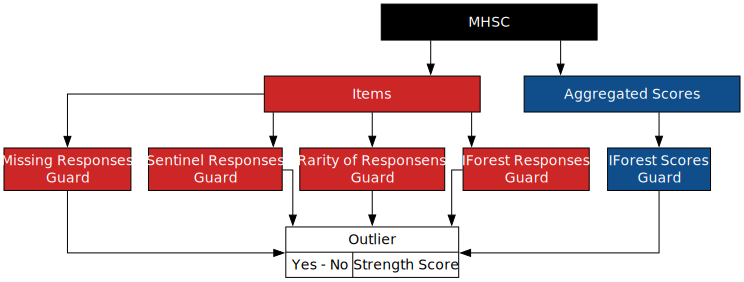

In [10]:
from graphviz import Source
# Create Digraph object
src = '''
digraph G {
  fontname="Trebuchet MS,Helvetica,Arial,sans-serif"
  node [fontname="Trebuchet MS,Helvetica,Arial,sans-serif"]
  edge [fontname="Trebuchet MS,Helvetica,Arial,sans-serif"]
  splines=ortho
  subgraph {
    2 [shape=box, label="MHSC", width=3, style=filled, fillcolor="black", fontcolor="white"]
    3 [shape=box label="Items", width=3, style=filled, fillcolor="firebrick3", fontcolor="white"]
    4 [shape=box label="Aggregated Scores", width=3, style=filled, fillcolor="dodgerblue4", fontcolor="white"]
    5 [shape=box, label="Missing Responses\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    6 [shape=box, label="Sentinel Responses\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    7 [shape=box, label="Rarity of Responsens\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    8 [shape=box, label="IForest Responses\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    9 [shape=box, label="IForest Scores\nGuard", style=filled, fillcolor="dodgerblue4", fontcolor="white"]
    10 [shape=record label="{ Outlier |{Yes - No|Strength Score}}" ]
    2 -> {3; 4;}
    3 -> {5;6;7;8}
    4 -> 9
    {5;6;7;8;9;} -> 10;
  }
}
'''
flow = Source(src)
flow.render("./media/flow")
Source(src)

## 2.2 Pre train relevant steps of pipeline

In [11]:
# set variable
need_retrain = True

# compute aggregated score function
def compute_mhsc_parts(df):
    df["mhsc_part01_tot"] = df.filter(regex="mhsc_01").sum(axis=1)
    df["mhsc_part02_tot"] = df.filter(regex="mhsc_02").sum(axis=1)
    df["mhsc_part03_tot"] = df.filter(regex="mhsc_03").sum(axis=1)
    df["mhsc_part04_tot"] = df.filter(regex="mhsc_04").sum(axis=1)
    return df

# add aggregated scores to dataset
df = compute_mhsc_parts(df)

# retrain relevant steps of pipe
# retraining is needed when dataset changes substantially
if need_retrain:
    
    # compute unique sequence of items
    sequences =  df.filter(regex="mhsc_01|mhsc_03").astype(str).sum(axis=1).value_counts()
    recurrent_sequences = (sequences[sequences == 1]).index.to_list()
    
    # isolation forests
    isof_items, isof_parts = IForest(random_state = 42), IForest(random_state = 42)
    df_mhsc_items = df.filter(regex="mhsc_\d")
    df_mhsc_parts = df.filter(regex="mhsc_part")
    isof_items.fit(df_mhsc_items)
    isof_parts.fit(df_mhsc_parts)  

## 2.3 Pipeline Guards

### 2.3.1 Missingness Guard

In [12]:
def missing_items_guard(df):
    # check whether there are any missing items
    # -1 there are missing items
    # 1 no missing items
    df["outlier_missing"] =\
        df.filter(regex="mhsc").apply(lambda x: np.where(x.isnull().any(), -1, 1), axis=1)
    return df

### 2.3.2 Sentinel Items Guard

In [13]:
def sentinel_items_guard(df):
    # -1 at least 1 sentinel item is positive
    # 1 sentinel items are all negative
    def check_conditions(s):
        # self harm or harm to other is positive
        c1 = (s[["mhsc_01_05"]] != 0).any()
        # drug comsumptiom is positive
        c2 = (s[["mhsc_02_04", "mhsc_02_05"]] != 0).any()
        # ongoing psy treatments or problems with law are positive
        c3 = (s[["mhsc_03_01", "mhsc_03_05"]] != 0).any()
        # low perceived psychological well-being is positive 
        c4 = s["mhsc_04_01"] < 6
        # compute sentinel outlier
        sentinel = -1 if pd.Series([c1,c2,c3,c4]).any() else 1
        return sentinel
    # add sentinel items guard
    df["outlier_sentinel"] = df.apply(check_conditions, axis=1)
    # return df
    return df

### 2.3.3 Rarity Guard

In [14]:
def rarity_of_sequence_guard(df, recurrent_sequences):
    # -1 items sequence is unique
    # 1 items sequence is not unique
    df["outlier_uniqueness"] = (
        np.where(df.filter(regex="mhsc_01|mhsc_03").astype(str).sum(axis=1).isin(recurrent_sequences), -1, 1)
    )
    return df

### 2.3.4 Isolation Forests Guards

In [15]:
def isofs_guard(df, isof_items, isof_parts):
    # -1 isolation forest predict observation to be outlier
    # 1 isolation forest predict observation to be inlier
    
    # set constant threshold
    OUTLIER_THRESHOLD = .9
    # filter data to feed isolation forests
    df_mhsc_items = df.filter(regex="mhsc_\d")
    df_mhsc_parts = df.filter(regex="mhsc_part") 
    # set isofs
    isofs = [
        ("isof_items", isof_items, df_mhsc_items, OUTLIER_THRESHOLD), 
        ("isof_parts", isof_parts, df_mhsc_parts, OUTLIER_THRESHOLD),
    ]
    # compute isolation forests
    for label, isof, data, threshold in isofs:
        decision_col, outlier_col = f"decision_{label}", f"outlier_{label}"
        df[decision_col] = isof.decision_function(data.values)
        df[outlier_col] = np.where(df[decision_col] >= df[decision_col].quantile(threshold), -1, 1)
    return df

### 2.3.5 Outlierness score

In [16]:
def outlierness_score(df):
    # 0 = no outlier
    # .2 = moderate outlier
    # .4 = strong outlier
    # .6 = strong outlier
    # .8 = extreme outlier
    # 1 = extreme outlier
    def compute_strength(x):
        score = 0
        # positive sentinel items dersrve high attention
        if x["outlier_sentinel"] == -1: score = .08
        # choose the highest computed value for strength score
        score = np.max([((x == -1).sum() / x.shape[0]), score])
        return score
    df["outlierness_score"] = df.filter(regex="outlier").apply(compute_strength, axis=1)
    return df

##  2.4 Apply pipeline to detect outliers

In [17]:
# apply pipe
df = (df
        .pipe(missing_items_guard)
        .pipe(sentinel_items_guard)
        .pipe(rarity_of_sequence_guard, recurrent_sequences = recurrent_sequences)
        .pipe(isofs_guard, isof_items=isof_items, isof_parts=isof_parts)
        .pipe(outlierness_score)
     )

df.head(2)

,bio_gender,bio_age,bio_job,bio_status,enac_self_assessment,enac_self_report_atypical,enac_interview_atypical,enac_need_referral,mhsc_01_01,mhsc_01_02,...,mhsc_part03_tot,mhsc_part04_tot,outlier_missing,outlier_sentinel,outlier_uniqueness,decision_isof_items,outlier_isof_items,decision_isof_parts,outlier_isof_parts,outlierness_score
bio_id,,,,,,,,,,,,,,,,,,,,,
1,F,17-30,Cabin Crew,Civilian,7,0,0,0,1,0,...,0,7,1,1,1,-0.056392,1,-0.061204,1,0.0
2,F,17-30,Cabin Crew,Civilian,8,0,0,0,0,0,...,0,8,1,1,1,-0.167555,1,-0.115000,1,0.0


# 3. IDENTIFIED OUTLIERS

## 3.1 Count and percentages of outliers

In [18]:
# outliers count
count_of_outliers = df.filter(regex="outlier_").apply(lambda x: (x==-1).any(), axis=1).sum().astype(int)
# percentageof outliers
perc_of_otuliers = round(count_of_outliers / df.shape[0] * 100, 1)

# table
(
    pd.DataFrame({
        "Total observations": [df.shape[0]],
        "Count of outliers": [count_of_outliers], 
        "% of outliers over total": [perc_of_otuliers]})
        .style
            .hide()
            .format(precision=2)
)

Total observations,Count of outliers,% of outliers over total
240,42,17.50


## 3.2 Percentages of outliers captured by pipeline steps

In [19]:
outliers_columns = df.filter(regex="outlier_").columns.to_list()

outliers_by_step = (df[(df[outliers_columns] == -1).any(axis=1)][outliers_columns])

def get_type_of_detection_strategy(x):
    x = x.iloc[:, :-1].astype(int).T
    return x.apply(
        lambda y: y.index[y==-1].to_list()[0] if y.clip(-1,0).sum() == -1 
            else "any combination of steps", axis=0
    )

(
    (outliers_by_step
        .astype(str)
        .value_counts(normalize=True, sort=False)
        .reset_index(drop=False)
        .sort_values(by=outliers_columns)
        .assign(strategy=lambda x: get_type_of_detection_strategy(x))
        .groupby("strategy")[["proportion"]]
            .sum().sort_values(by="proportion")
        .reset_index(drop=False)
        .rename(columns={"strategy":"Outliers detectd by","proportion":"%"})
        .style
            .hide()
            .format(lambda x: round(x*100, 1), subset=["%"])
    )
)

Outliers detectd by,%
outlier_isof_items,2.4
outlier_sentinel,4.8
outlier_isof_parts,9.5
outlier_uniqueness,14.3
any combination of steps,69.0


## 3.3 Percentages of outliers in dataset by outlierness score

In [20]:
OUTLIER_TYPE= {
    "-4.0" : "extreme outlier",
    "-4" : "extreme outlier",
    "-3.0" : "strong outlier",
    "-3" : "strong outlier",
    "-2.0" : "strong outlier",
    "-2" : "strong outlier",
    "-1.0" : "moderate outlier",
    "-1" : "moderate outlier",
    "0.0"  : "no outlier",
    "0"  : "no outlier"
}

In [21]:
# select outlier columns (except missing, as in our dataset there are no profiles with missing items)
outliers_columns = df.filter(regex="outlier_(?!missing)").columns.to_list()

# compute outliers data
outliers_data = (df[outliers_columns].value_counts(normalize=True).to_frame()\
    .iloc[1:].reset_index(drop=False))

outlier_scores = df.pivot_table(index=outliers_columns, values="bio_gender", aggfunc=np.size, observed=False)\
    .reset_index(drop=False)

type_of_outliers =  outlier_scores\
    .sort_values(by=outliers_columns)\
    .assign(type_of_outlier= lambda x: x.clip(-1,0).sum(axis=1).astype(str).apply(lambda y:OUTLIER_TYPE[y]))\
    .groupby("type_of_outlier")[["bio_gender"]].sum() / df.shape[0]  

(
    (type_of_outliers
        .reindex(["no outlier", "moderate outlier","strong outlier","extreme outlier"])
        .reset_index(drop=False)
        .rename(columns={"index":"Type of outlier", "bio_gender": "%"})
        .style
            .hide()
            .format(lambda x: round(x*100, 1), subset=["%"])
    )
)

type_of_outlier,%
no outlier,82.5
moderate outlier,5.4
strong outlier,9.6
extreme outlier,2.5


## 3.4  Percentages of type of outliers type by job

In [22]:
outliers_columns = [f"outlier_{o}" for o in ["sentinel","uniqueness","isof_items", "isof_parts"]]

outlier_scores_by_job = (df.pivot_table(
    index=outliers_columns, columns="bio_job", values="bio_gender", fill_value=0, aggfunc=np.size, observed=False)
     .reset_index(drop=False)
)

(
    (outlier_scores_by_job[outlier_scores_by_job[outliers_columns]
        .sort_values(by=outliers_columns)
        .sum(axis=1) < 4]
        .assign(type_of_outlier=
                lambda x: x.clip(-1,0).sum(axis=1).astype(str).apply(lambda y:OUTLIER_TYPE[y])
        )
        .iloc[:, 4:]
        .groupby("type_of_outlier")
            .sum() / count_of_outliers
    )
     .reset_index(drop=False)
     .rename(columns=
        {"index":"Type of Outlier", "Pilot":"Pilots","Pilot Applicant":"Applicants","Cabin Crew":"Crew"})
    .loc[:,["type_of_outlier","Pilots","Crew","Applicants"]]
    .style
        .hide()
        .background_gradient(cmap="GnBu", axis=1)
        .format(lambda x: round(x*100, 1), subset=["Pilots","Applicants","Crew"])
)

type_of_outlier,Pilots,Crew,Applicants
extreme outlier,0.0,9.5,4.8
moderate outlier,19.0,2.4,9.5
strong outlier,16.7,14.3,23.8


# 4 Outliers plots

## 4.1 Data for plots

In [23]:
SPLINES_COLOR = "#204571"

In [24]:
# pre process data
X_items = df.filter(regex="mhsc_\d")
X_items = MinMaxScaler().fit_transform(X_items)

X_parts = df.filter(regex="mhsc_part")
X_parts = MinMaxScaler().fit_transform(X_parts)

In [25]:
# init pip steps
min_max = MinMaxScaler()
svd = TruncatedSVD()

# define pipe
pipe = Pipeline(steps=[("min_max", min_max),('svd', svd)])

# add truncated SVD factors
data = pd.concat([
    df.reset_index(drop=False), 
    pd.DataFrame(pipe.fit_transform(df.filter(regex="mhsc_\d")))
], axis=1)

# rename columns
data.columns = [*data.columns[:-2], "f1", "f2"]

# show df
data.head()

,bio_id,bio_gender,bio_age,bio_job,bio_status,enac_self_assessment,enac_self_report_atypical,enac_interview_atypical,enac_need_referral,mhsc_01_01,...,outlier_missing,outlier_sentinel,outlier_uniqueness,decision_isof_items,outlier_isof_items,decision_isof_parts,outlier_isof_parts,outlierness_score,f1,f2
0,1,F,17-30,Cabin Crew,Civilian,7,0,0,0,1,...,1,1,1,-0.056392,1,-0.061204,1,0.0,1.114113,0.378598
1,2,F,17-30,Cabin Crew,Civilian,8,0,0,0,0,...,1,1,1,-0.167555,1,-0.115000,1,0.0,0.493377,-0.236792
2,3,M,17-30,Pilot,Civilian,9,0,0,0,0,...,1,1,1,-0.121538,1,-0.062365,1,0.0,1.403823,-0.121519
3,4,M,17-30,Pilot Applicant,Civilian,8,1,0,0,0,...,1,1,-1,-0.027645,1,-0.024167,1,0.2,1.021917,0.056913
4,5,M,31-50,Cabin Crew,Civilian,8,0,0,0,0,...,1,1,1,-0.172826,1,-0.174158,1,0.0,0.581983,-0.238403


## 4.2 Scatterplot of outliers by pipeline steps

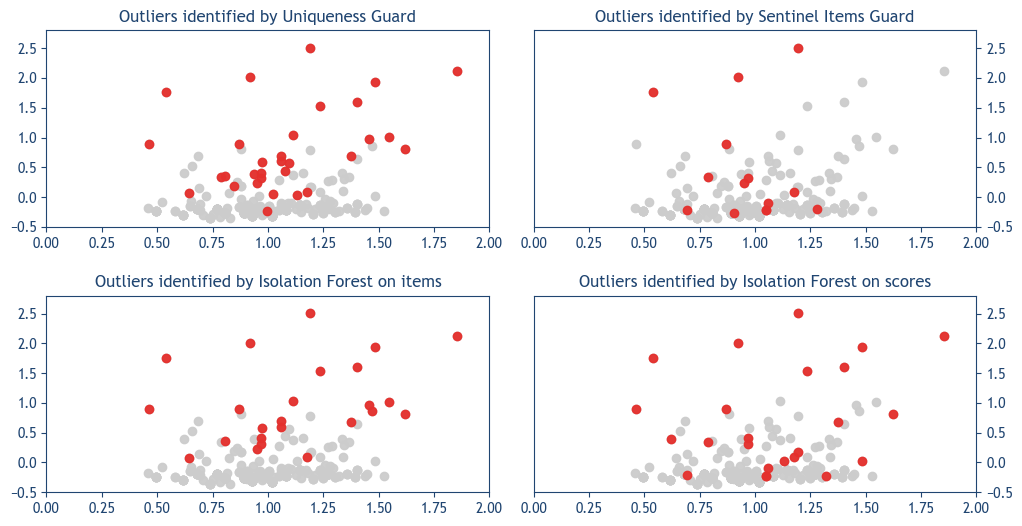

In [26]:
fig = plt.figure(figsize=(12,6))

gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

alpha=.95

for algo, ax in zip(["uniqueness", "sentinel", "isof_items", "isof_parts"], [ax1, ax2, ax3, ax4]):
    outliers_mask =  data.loc[:, f"outlier_{algo}"] == -1
    ax.scatter(data["f1"], data["f2"], c="#ccc", alpha=alpha)
    ax.scatter(
        data.loc[outliers_mask, "f1"], 
        data.loc[outliers_mask, "f2"], 
        c="#e5302d", 
        alpha=alpha
    )
    #for index, row in data.copy().reset_index(drop=False).iterrows():
        #ax.annotate(row["bio_id"], (row["svd_f1"], row["svd_f2"]))
        
    
for idx, ax in enumerate([ax1, ax2, ax3, ax4], 1):
    if idx % 2 == 0: ax.yaxis.tick_right() 
    ax.set_xlim(0, 2)
    ax.set_ylim(-.5, 2.8)
    
    ax.tick_params(color=SPLINES_COLOR, labelcolor=SPLINES_COLOR)
    for spine in ax.spines.values():
        spine.set_edgecolor(SPLINES_COLOR)

ax1.set_title("Outliers identified by Uniqueness Guard", c=SPLINES_COLOR)
ax2.set_title("Outliers identified by Sentinel Items Guard", c=SPLINES_COLOR)
ax3.set_title("Outliers identified by Isolation Forest on items", c=SPLINES_COLOR)
ax4.set_title("Outliers identified by Isolation Forest on scores", c=SPLINES_COLOR)
        
plt.subplots_adjust(wspace=0.1, hspace=.35)
plt.savefig("./media/plot1.pdf", bbox_inches='tight')

## 4.3 Dist. of outlierness scores and plot of outliers with size prop. to strength scores

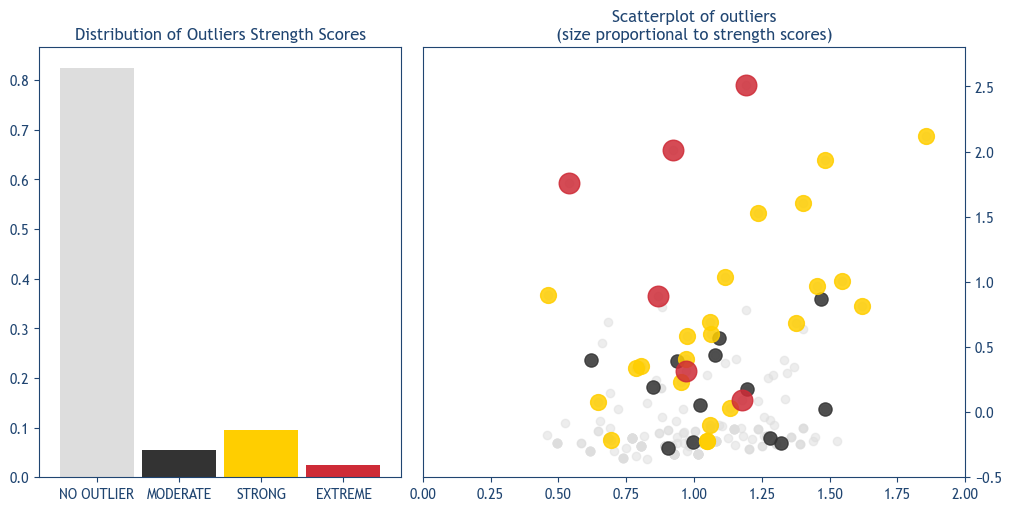

In [27]:
NO_OUTLIER_COLOR = "#DDDDDD"
MODERATE_OUTLIER_COLOR = "#333333"
STRONG_OUTLIER_COLOR = "#ffce00"
EXTREME_OUTLIER_COLOR = "#CE2B37"

fig = plt.figure(figsize=(10, 5), layout="constrained")

gs = GridSpec(1, 5, figure=fig)

# bar plot
ax1 = fig.add_subplot(gs[0, :2])
ax1_data = type_of_outliers.squeeze().reindex(["no outlier", "moderate outlier","strong outlier","extreme outlier"])
(
    ax1_data
        .plot.bar(
         width=.9, 
         color = [NO_OUTLIER_COLOR,MODERATE_OUTLIER_COLOR,STRONG_OUTLIER_COLOR,EXTREME_OUTLIER_COLOR],
         ax=ax1
     )
)
ax1.set_xlabel("")
ax1.set_xticks(ax1.get_xticks(), ["NO OUTLIER","MODERATE","STRONG","EXTREME"], rotation=0)
ax1.set_title(f"Distribution of Outliers Strength Scores", c=SPLINES_COLOR);

# scatter plot
ax2 = fig.add_subplot(gs[0, 2:])
ax2.scatter(data["f1"], data["f2"], c="#DDDDDD", alpha=.5)

outliers_moderate = (data.filter(regex="outlier") == -1).sum(axis=1) == 1
outliers_strong = np.logical_or((data.filter(regex="outlier") == -1).sum(axis=1) == 2, (data.filter(regex="outlier") == -1).sum(axis=1) == 3)
outliers_extreme = (data.filter(regex="outlier") == -1).sum(axis=1) == 4

for outlier_mask, color, size in [ 
    (outliers_moderate, MODERATE_OUTLIER_COLOR, 90), 
    (outliers_strong, STRONG_OUTLIER_COLOR, 130),
    (outliers_extreme, EXTREME_OUTLIER_COLOR, 220)
]:
    ax2.scatter(
        data.loc[outlier_mask, "f1"], 
        data.loc[outlier_mask, "f2"], 
        s=size, 
        c=color,
        alpha=.85
    )
ax2.set_title(f"Scatterplot of outliers\n(size proportional to strength scores)", c=SPLINES_COLOR);
ax2.yaxis.tick_right();
ax2.set_xlim(0,2)
ax2.set_ylim(-.5,2.8);

for idx, ax in enumerate([ax1, ax2], 1):
    ax.tick_params(color=SPLINES_COLOR, labelcolor=SPLINES_COLOR)
    for spine in ax.spines.values():
        spine.set_edgecolor(SPLINES_COLOR)

plt.savefig("./media/plot2.pdf", bbox_inches='tight')
